In [66]:
from typing import List
import random
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [67]:
class MLP:
    def __init__(self, npl: List[int]): # neurons per layer, d in the slides
        self.npl = list(npl)
        self.L = len(npl)-1  # last layer index
        self.W = []  # weights weight of layer l going from neuron i to neuron j: W[l][i][j]

        for l in range(self.L + 1):
            self.W.append([])
            if (l == 0) : continue # no weights for input layer, to be consistent with indexing (W[1] are weights going to layer 1)

            for i in range(0, self.npl[l-1]+1): # +1 for bias neuron
                self.W[l].append([])
                for j in range(0, self.npl[l]+1):
                    rdm_value = random.random() * 2 - 1  # random value between -1 and 1
                    self.W[l][i].append(0.0 if j == 0 else rdm_value) # no weights going to bias neuron so set to 0.0 if j == 0 corresponds to bias neuron

        self.X = []  # activations of layer l neuron i: X[l][i]
        self.deltas = []  # deltas of layer l neuron i: deltas[l][i]

        for l in range(self.L + 1):
            self.X.append([])
            self.deltas.append([])

            for j in range(0, self.npl[l] + 1):
                self.X[l].append(1.0 if j==0 else 0.0)
                self.deltas[l].append(0.0)

    def _propagate(self, inputs: List[float], is_classification: bool):
        assert(len(inputs) == self.npl[0]) # check if inputs is the same size as nbs of layers

        # update first layer
        for j in range(len(inputs)):
            self.X[0][j + 1] = inputs[j] # update X for input (layer 0) and keep the weight

        # update all layers until output
        for l in range(1, self.L + 1):
            for j in range(1, self.npl[l]+1):
                signal = 0.0
                for i in range(0, self.npl[l-1] + 1):
                    signal += self.W[l][i][j] * self.X[l - 1][i]
                if (is_classification or l != self.L):
                    self.X[l][j] = math.tanh(signal)
                else:
                    self.X[l][j] = signal # use identity method only when regression and updating last layer

    def predict(self, inputs: List[float], is_classification: bool):
        self._propagate(inputs, is_classification)
        return self.X[self.L][1:]
    
    def train(self,
              all_samples_inputs: List[List[float]],
              all_samples_expected_outputs: List[List[float]],
              is_classification: bool,
              num_iter: int,
              alpha: float):
        
        assert(len(all_samples_inputs) == len(all_samples_expected_outputs))
        for _ in tqdm(range(num_iter)):
            k = random.randint(0, len(all_samples_inputs) - 1)
            inputs_k = all_samples_inputs[k]
            labels_k = all_samples_expected_outputs[k]

            self._propagate(inputs_k, is_classification) # mise à jour des sorties de tous les neurons (self.X)

            for j in range(1, self.npl[self.L] + 1): # start with 1 to avoid last layer 1
                self.deltas[self.L][j] = (self.X[self.L][j] - labels_k[j-1])
                if (is_classification) :
                    self.deltas[self.L][j] *= (1.0 - self.X[self.L][j]**2)

            # get the deltas
            for l in reversed(range(2, self.L + 1)):
                for i in range(1, self.npl[l-1] + 1):
                    total = 0.0
                    for j in range(1, self.npl[l] + 1):
                        total += self.W[l][i][j] * self.deltas[l][j]
                    total *= (1.0 - self.X[l-1][i] ** 2)
                    self.deltas[l-1][i] = total

            # update weights
            for l in range(1, self.L + 1):
                for i in range(0, self.npl[l-1] + 1):
                    for j in range(1, self.npl[l] + 1):
                        self.W[l][i][j] -= alpha*self.X[l-1][i]*self.deltas[l][j]

In [68]:
mlp = MLP([2, 3, 1])
print(mlp.X)
print(mlp.W)
print(mlp.deltas)

[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0]]
[[], [[0.0, -0.3072870966598158, -0.9702913138846971, -0.1883595718551736], [0.0, 0.024178113634211185, -0.05669511093654367, 0.5425799604412611], [0.0, 0.06459322845641369, 0.3932478972983089, -0.1386698955697525]], [[0.0, 0.08641932468806313], [0.0, -0.62383401610077], [0.0, -0.5580974048173721], [0.0, 0.990772952205029]]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0]]


In [69]:
mlp.predict([42.0, 53.0], True)

[-0.10403971842301654]

In [70]:
xor_inputs = [
    [0.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0]
]

xor_expected_ouputs = [
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
]

for inp in xor_inputs:
    print(mlp.predict(inp, True))
mlp.train(xor_inputs, xor_expected_ouputs, True, 100000, 0.01)

for inp in xor_inputs:
    print(mlp.predict(inp, True))

[0.4666485401332685]
[0.772571467980034]
[0.20933734685131683]
[0.6314376357134879]


100%|██████████| 100000/100000 [00:00<00:00, 249142.94it/s]

[-0.9779398393260245]
[0.9785101138674821]
[0.9774566333474044]
[-0.9851055118767836]


In [71]:
class MLP_matrix:
    def __init__(self, npl: List[int]): # neurons per layer, d in the slides
        self.npl = list(npl)
        self.L = len(npl)-1  # last layer index
        # weight of layer l going from neuron i to neuron j: W[l][i][j]
        self.W = []
        self.W.append(np.array([]))  # no weights for input layer, to be consistent with indexing (W[1] are weights going to layer 1)

        for l in range(1, self.L + 1):
            self.W.append(np.random.uniform(-1, 1, (self.npl[l-1]+1, self.npl[l]+1)))  # +1 for bias neuron from layer l-1 to layer l
            self.W[l][ :, 0] = 0.0  # no weights going to bias neuron so set to 0.0, j == 0 corresponds to bias neuron

        self.X = []  # activations of layer l neuron i: X[l][i]
        self.deltas = []  # deltas of layer l neuron i: deltas[l][i]

        for l in range(self.L + 1):
            self.X.append(np.zeros((self.npl[l] + 1, 1)))
            self.X[l][0][0] = 1.0  # bias neuron

            self.deltas.append(np.zeros((self.npl[l] + 1, 1)))

    def _propagate(self, inputs: np.ndarray, is_classification: bool):
        assert(len(inputs) == self.npl[0]) # check if inputs is the same size as nbs of layers

        self.X[0][1:] = inputs # update the X row vector for input layer (keeping bias neuron)

        # update all layers until output
        for l in range(1, self.L + 1):
            signal = self.W[l].T @ self.X[l - 1]   # matrix multiplication

            if (is_classification or l != self.L):
                self.X[l] = np.tanh(signal)
            else:
                self.X[l] = signal # use identity method only when regression and updating last layer

    def predict(self, inputs: np.ndarray, is_classification: bool):
        self._propagate(inputs, is_classification)
        return self.X[self.L][1:]
    
    def train(self,
              X: np.ndarray,
              Y: np.ndarray,
              is_classification: bool,
              num_iter: int,
              alpha: float):
        
        assert(X.shape[1] == Y.shape[1])

        MSE = np.zeros((num_iter//100-1,))
        error = 0

        for i in tqdm(range(num_iter)):
            k = np.random.randint(0, X.shape[1]) # pick a random sample
            X_k = X[:,k].reshape(-1, 1) # get the k-th sample as a column vector
            Y_k = np.ones((Y.shape[0]+1, 1))
            Y_k[1:] = Y[:,k].reshape(-1, 1) # add bias neuron at index 0 (easy to handle with matrix operations)

            self._propagate(X_k, is_classification) # mise à jour des sorties de tous les neurons (self.X)

            self.deltas[self.L] = self.X[self.L] - Y_k

            error += np.mean(self.deltas[self.L]**2)
            if i % 100 == 0 and i > 0:
                MSE[i//100-1] = error / 100.0
                error = 0

            if is_classification:
                self.deltas[self.L] *= (1.0 - self.X[self.L]**2) # square element wise

            # get the deltas
            for l in reversed(range(2, self.L + 1)):
                self.deltas[l-1] = (1.0 - self.X[l-1]**2) * (self.W[l] @ self.deltas[l])

            # update weights
            for l in range(1, self.L + 1):
                self.W[l] -= alpha*self.X[l-1]*self.deltas[l].T

        return MSE

In [72]:
mlp_mat = MLP_matrix([2, 2, 1])
print(mlp_mat.X)
print(mlp_mat.W)
print(mlp_mat.deltas)

[array([[1.],
       [0.],
       [0.]]), array([[1.],
       [0.],
       [0.]]), array([[1.],
       [0.]])]
[array([], dtype=float64), array([[ 0.        , -0.48756719,  0.60690322],
       [ 0.        ,  0.7079099 ,  0.97303345],
       [ 0.        , -0.31186984, -0.33013185]]), array([[0.        , 0.72980519],
       [0.        , 0.22127826],
       [0.        , 0.77212769]])]
[array([[0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.]]), array([[0.],
       [0.]])]


In [73]:
mlp_mat.predict(np.array([[42.0], [53.0]]), True)

array([[0.75881089]])

[[0.13825986]]
[[0.07471331]]
[[-0.2304717]]
[[0.34730931]]


100%|██████████| 10000/10000 [00:00<00:00, 62737.42it/s]


[[-0.93857412]]
[[-0.90607572]]
[[0.90004598]]
[[0.9070017]]


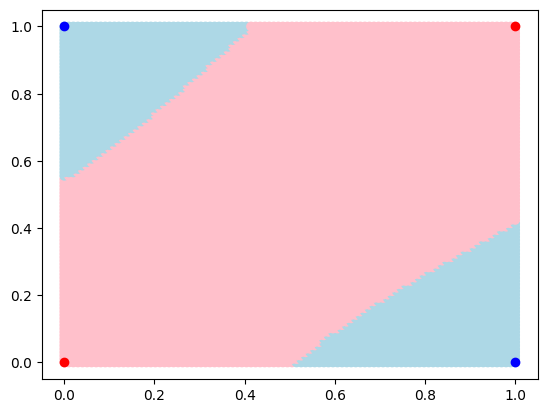

In [74]:
mlp_mat = MLP_matrix([2, 3, 1])

xor_inputs = np.array([
    [0.0, 1.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 1.0],
])

xor_expected_ouputs =np.array([
    [-1.0, -1.0, 1.0,1.0]
])

for col in range(xor_inputs.shape[1]):
    inp = xor_inputs[:, col].reshape(-1, 1)
    print(mlp_mat.predict(inp, True))
mlp_mat.train(xor_inputs, xor_expected_ouputs, True, 10000, 0.01)

for col in range(xor_inputs.shape[1]):
    inp = xor_inputs[:, col].reshape(-1, 1)
    print(mlp_mat.predict(inp, True))

# Create grid points using meshgrid
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)

# Reshape into input array for predict_batch
X_bg = np.column_stack((X1.ravel(), X2.ravel()))

predictions = np.zeros((X_bg.shape[0], 1))
# Get predictions for all points at once
for i in range(X_bg.shape[0]):
    inp = X_bg[i].reshape(-1, 1)
    predictions[i] = mlp_mat.predict(inp, True)

# Create color array
colors = np.where(predictions.reshape((-1)) < 0, 'pink', 'lightblue')

# Plot scatter
plt.scatter(X_bg[:,0], X_bg[:,1], c=colors)
plt.scatter(xor_inputs[0, 2:], xor_inputs[1, 2:], color='blue')
plt.scatter(xor_inputs[0, :2], xor_inputs[1, :2], color='red')
plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 64925.80it/s]


[[0.98666338]]
[[-0.99277125]]
[[-0.99034276]]


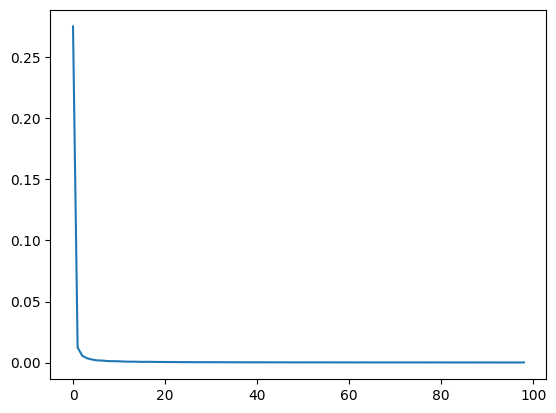

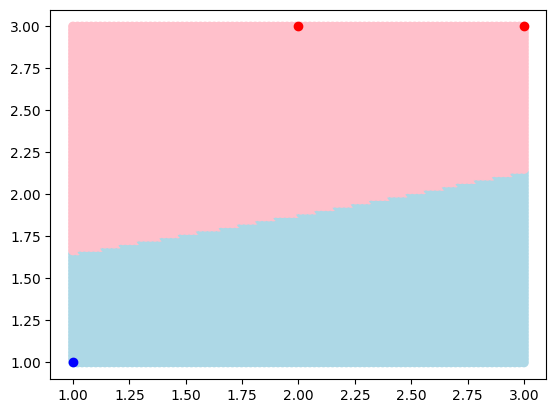

In [75]:
mlp_mat = MLP_matrix([2, 3, 1])

X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y = np.array([[
      1,
      -1,
      -1
]])

error = mlp_mat.train(X.T, Y, True, 10000, 0.1)

plt.plot(error)

for i in range(X.shape[0]):
    inp = X[i].reshape(-1, 1)
    print(mlp_mat.predict(inp, True))

plt.show()

# Create grid points using meshgrid
x1 = np.linspace(1, 3, 100)
x2 = np.linspace(1, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# Reshape into input array for predict_batch
X_bg = np.column_stack((X1.ravel(), X2.ravel()))

predictions = np.zeros((X_bg.shape[0], 1))
# Get predictions for all points at once
for i in range(X_bg.shape[0]):
    inp = X_bg[i].reshape(-1, 1)
    predictions[i] = mlp_mat.predict(inp, True)

# Create color array
colors = np.where(predictions.reshape((-1)) < 0, 'pink', 'lightblue')

# Plot scatter
plt.scatter(X_bg[:,0], X_bg[:,1], c=colors)
plt.scatter(X[0, 0], X[0, 1], color='blue')
plt.scatter(X[1:3,0], X[1:3,1], color='red')
plt.show()

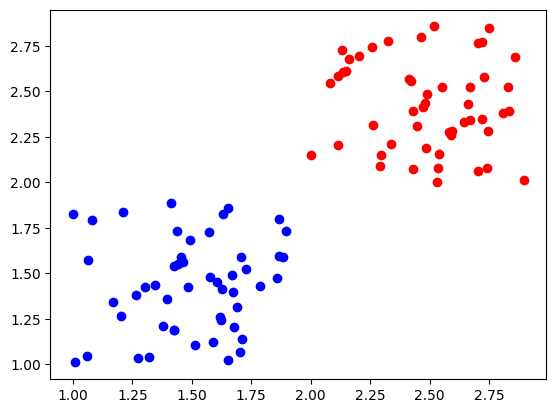

(100, 2)
(100, 1)


100%|██████████| 100000/100000 [00:01<00:00, 94868.04it/s]


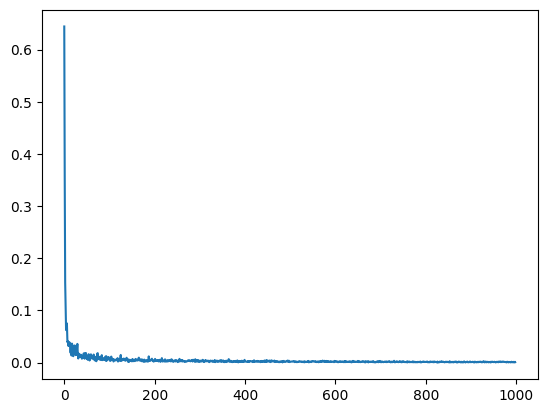

In [76]:
mlp_mat = MLP_matrix([2, 1])

X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 100000, 0.1)

plt.plot(error)
plt.show()


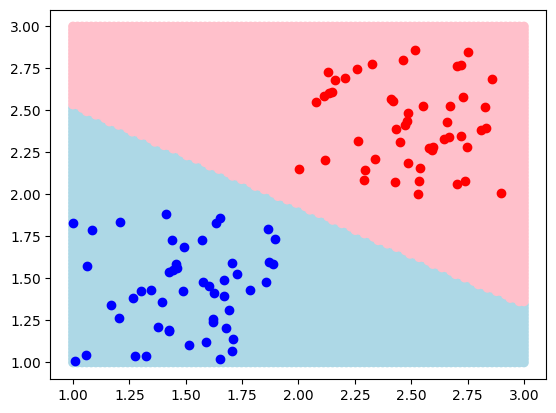

In [77]:

# Create grid points using meshgrid
x1 = np.linspace(1, 3, 100)
x2 = np.linspace(1, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# Reshape into input array for predict_batch
X_bg = np.column_stack((X1.ravel(), X2.ravel()))

predictions = np.zeros((X_bg.shape[0], 1))
# Get predictions for all points at once
for i in range(X_bg.shape[0]):
    inp = X_bg[i].reshape(-1, 1)
    predictions[i] = mlp_mat.predict(inp, True)

# Create color array
colors = np.where(predictions.reshape((-1)) < 0, 'pink', 'lightblue')

# Plot scatter
plt.scatter(X_bg[:,0], X_bg[:,1], c=colors)
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()

(500, 2)
(500, 1)


100%|██████████| 200000/200000 [00:03<00:00, 65345.93it/s]


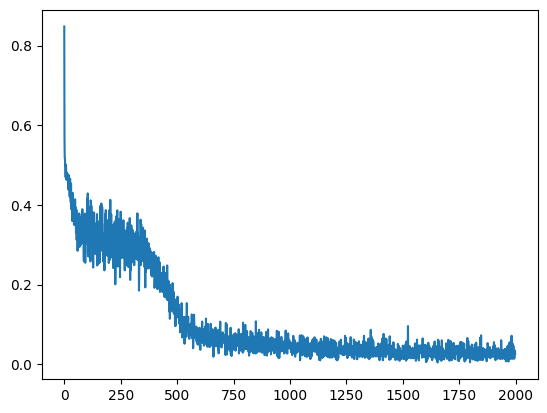

In [78]:
mlp_mat = MLP_matrix([2, 4, 1])

X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X]).reshape(-1, 1)

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 200000, 0.01)

plt.plot(error)
plt.show()


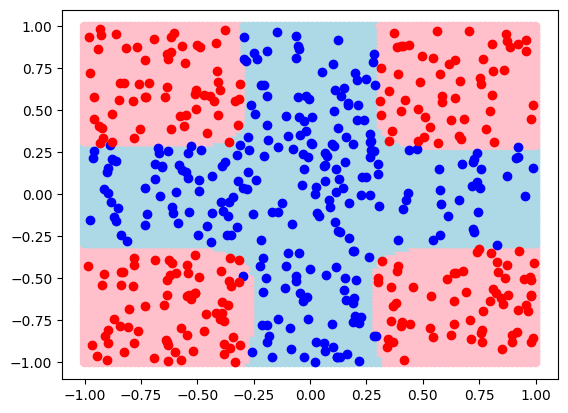

In [79]:
# Create grid points using meshgrid
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)

# Reshape into input array for predict_batch
X_bg = np.column_stack((X1.ravel(), X2.ravel()))

predictions = np.zeros((X_bg.shape[0], 1))
# Get predictions for all points at once
for i in range(X_bg.shape[0]):
    inp = X_bg[i].reshape(-1, 1)
    predictions[i] = mlp_mat.predict(inp, True)

# Create color array
colors = np.where(predictions.reshape((-1)) < 0, 'pink', 'lightblue')

# Plot scatter
plt.scatter(X_bg[:,0], X_bg[:,1], c=colors)
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,1], color='red')
plt.show()

(400, 2)
(400, 3)


100%|██████████| 10000/10000 [00:00<00:00, 95450.26it/s]


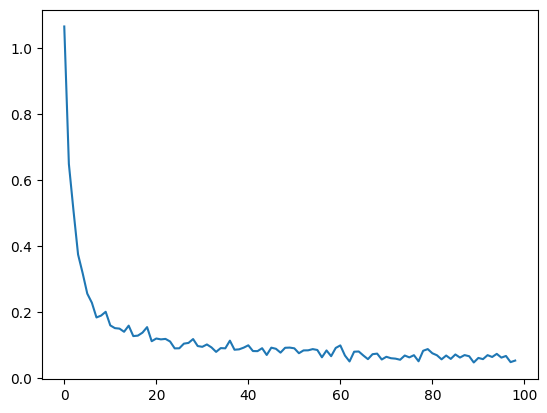

In [80]:
mlp_mat = MLP_matrix([2, 3])

X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, 1, -1] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, -1, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
              [-1, -1, -1]for p in X])

X = X[[not np.all(arr == [-1, -1, -1]) for arr in Y]]
Y = Y[[not np.all(arr == [-1, -1, -1]) for arr in Y]]



print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 10000, 0.01)

plt.plot(error)
plt.show()

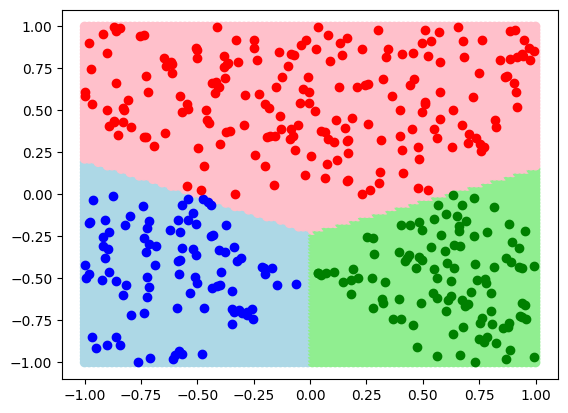

In [81]:
# Create grid points using meshgrid
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)

# Reshape into input array for predict_batch
X_bg = np.column_stack((X1.ravel(), X2.ravel()))

predictions = np.zeros((X_bg.shape[0], 3))
# Get predictions for all points at once
for i in range(X_bg.shape[0]):
    inp = X_bg[i].reshape(-1, 1)
    predictions[i] = mlp_mat.predict(inp, True).reshape(-1)

predicted_classes = np.argmax(predictions, axis=1)
class_colors = np.array(['lightblue', 'pink', 'lightgreen'])

# Use the predicted class indices to select the corresponding colors.
colors = class_colors[predicted_classes]


# Plot scatter
plt.scatter(X_bg[:,0], X_bg[:,1], c=colors)
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()

(1000, 2)
(1000, 3)


100%|██████████| 1000000/1000000 [00:21<00:00, 47021.66it/s]


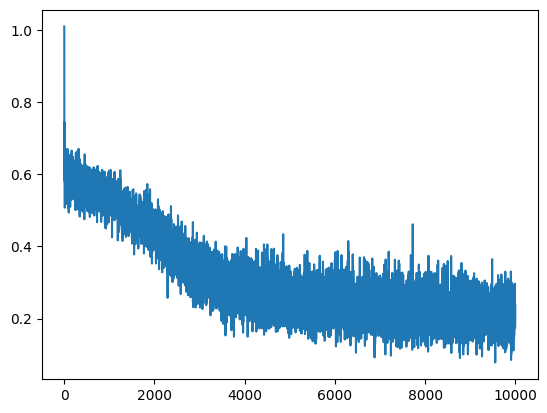

In [100]:
mlp_mat = MLP_matrix([2, 16, 16, 3])

X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [-1, 1, -1] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [-1, -1, 1] for p in X])

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 1000000, 0.01)

plt.plot(error)
plt.show()

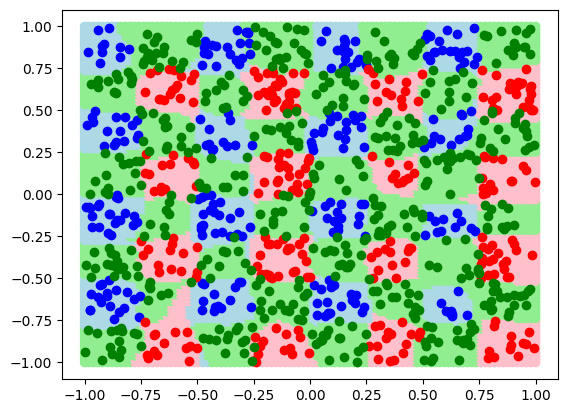

In [83]:
# Create grid points using meshgrid
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)

# Reshape into input array for predict_batch
X_bg = np.column_stack((X1.ravel(), X2.ravel()))

predictions = np.zeros((X_bg.shape[0], 3))
# Get predictions for all points at once
for i in range(X_bg.shape[0]):
    inp = X_bg[i].reshape(-1, 1)
    predictions[i] = mlp_mat.predict(inp, True).reshape(-1)

predicted_classes = np.argmax(predictions, axis=1)
class_colors = np.array(['lightblue', 'pink', 'lightgreen'])

# Use the predicted class indices to select the corresponding colors.
colors = class_colors[predicted_classes]


# Plot scatter
plt.scatter(X_bg[:,0], X_bg[:,1], c=colors)
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()

(2, 1)
(2, 1)


100%|██████████| 1000/1000 [00:00<00:00, 95232.02it/s]


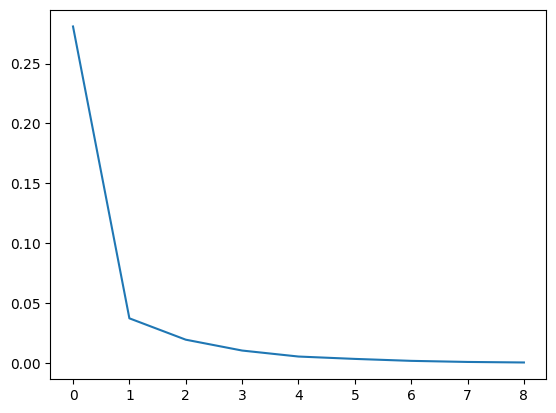

In [84]:
mlp_mat = MLP_matrix([1,1])

X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
]).reshape(-1, 1)

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, False, 1000, 0.04)

plt.plot(error)
plt.show()

(50, 1)
(50, 1)


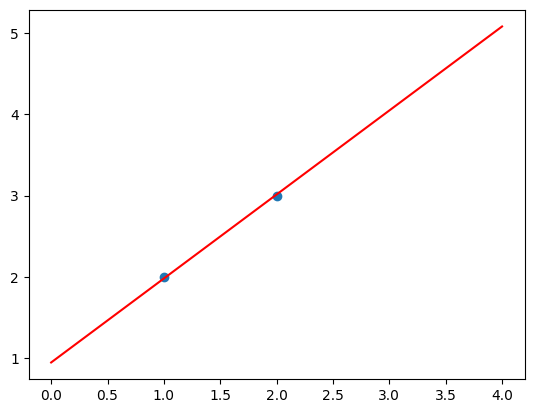

In [85]:
x_values = np.linspace(0, 4)
x_values = np.expand_dims(x_values, axis=1) # Make it a 2D array with shape (100, 1)

y_values = np.zeros((x_values.shape[0], 1))
# Get predictions for all points at once
for i in range(x_values.shape[0]):
    inp = x_values[i].reshape(-1, 1)
    y_values[i] = mlp_mat.predict(inp, False).reshape(-1)

plt.figure()

print(x_values.shape)
print(y_values.shape)

# Plot the line (x, y)
plt.plot(x_values, y_values, color='red')
plt.scatter(X, Y)

plt.show()

(3, 1)
(3, 1)


100%|██████████| 1000/1000 [00:00<00:00, 90878.25it/s]


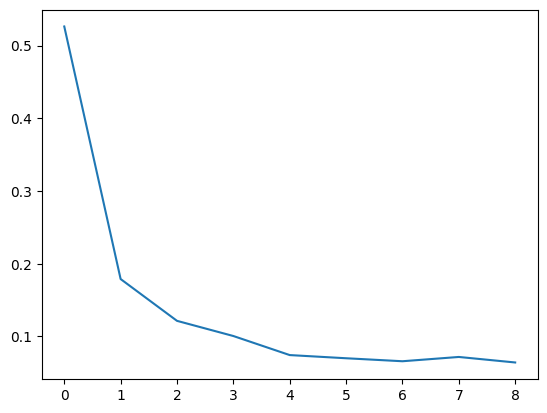

In [86]:
mlp_mat = MLP_matrix([1,1])

X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
]).reshape(-1, 1)

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, False, 1000, 0.04)

plt.plot(error)
plt.show()

(50, 1)
(50, 1)


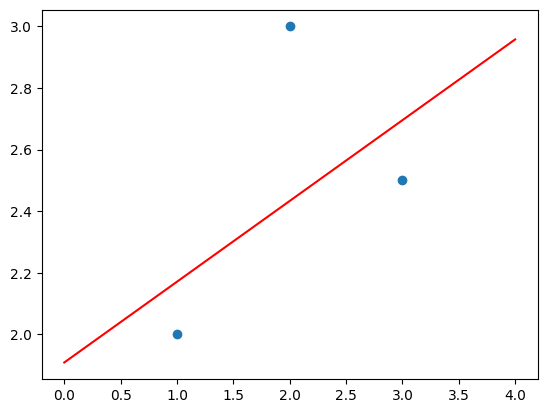

In [87]:
x_values = np.linspace(0, 4)
x_values = np.expand_dims(x_values, axis=1) # Make it a 2D array with shape (100, 1)

y_values = np.zeros((x_values.shape[0], 1))
# Get predictions for all points at once
for i in range(x_values.shape[0]):
    inp = x_values[i].reshape(-1, 1)
    y_values[i] = mlp_mat.predict(inp, False).reshape(-1)

plt.figure()

print(x_values.shape)
print(y_values.shape)

# Plot the line (x, y)
plt.plot(x_values, y_values, color='red')
plt.scatter(X, Y)

plt.show()

(3, 2)
(3,)


100%|██████████| 1000/1000 [00:00<00:00, 110907.61it/s]


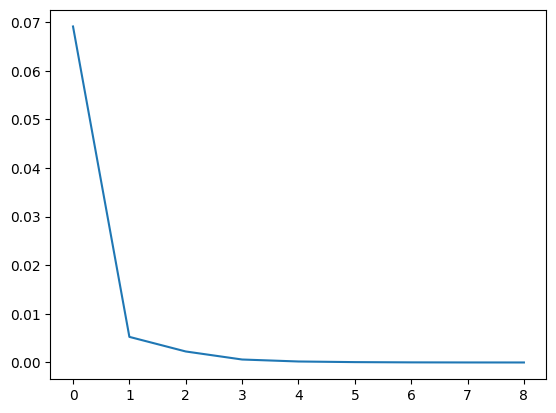

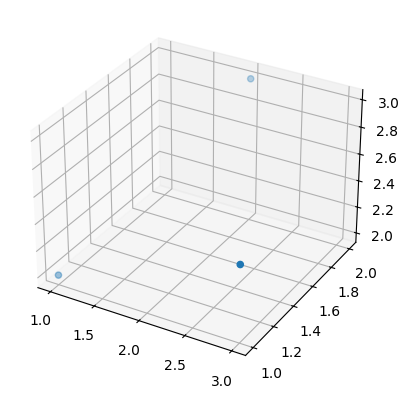

In [88]:
mlp_mat = MLP_matrix([2,1])

X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.reshape(-1, 1).T, False, 1000, 0.1)

plt.plot(error)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 

ax.scatter(X[:,0], X[:,1], Y)

plt.show()

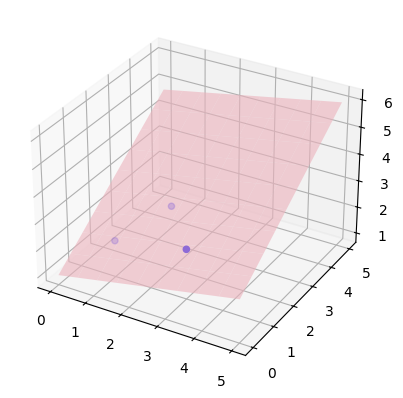

In [89]:
x1_values = np.linspace(0, 5, 10)  # 10 points from 0 to 10
x2_values = np.linspace(0, 5, 10)

# Create 2D grid from the two linspaces
x1_values, x2_values = np.meshgrid(x1_values, x2_values)

# flatten the grid to create input pairs
x1_values = x1_values.ravel()  # shape (100,)
x2_values = x2_values.ravel()

x_values = np.column_stack((x1_values, x2_values))

y_values = np.zeros((x_values.shape[0], 1))
# Get predictions for all points at once
for i in range(x_values.shape[0]):
    inp = x_values[i].reshape(-1, 1)
    y_values[i] = mlp_mat.predict(inp, False).reshape(-1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
# Reshape back to 2D grid (for surface plotting)
X1 = x_values[:, 0].reshape(10, 10)
X2 = x_values[:, 1].reshape(10, 10)
Y_pred = y_values.reshape(10, 10)

# Use plot_surface instead of scatter for smooth plane
ax.plot_surface(X1, X2, Y_pred, color='pink', alpha=0.6)
ax.scatter(X[:,0], X[:,1], Y, color='blue', label='Training data')
plt.show()

(3, 2)
(3,)


100%|██████████| 1000/1000 [00:00<00:00, 110975.10it/s]


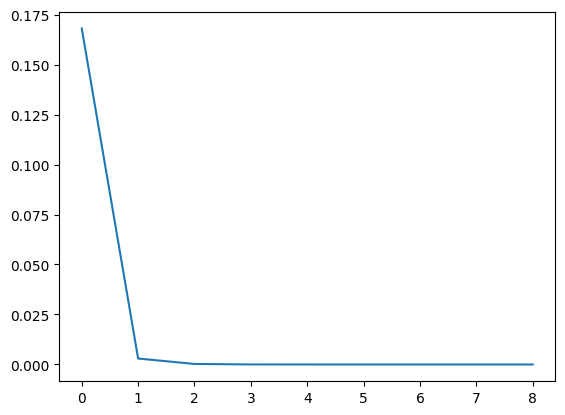

In [90]:
mlp_mat = MLP_matrix([2,1])

X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.reshape(-1, 1).T, False, 1000, 0.1)

plt.plot(error)
plt.show()

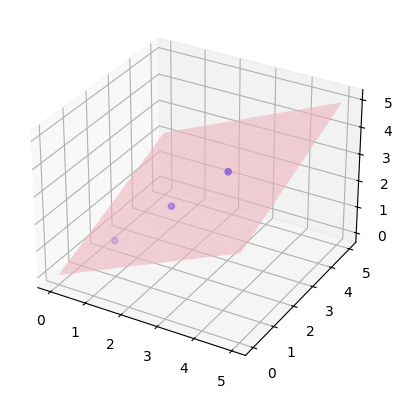

In [91]:
x1_values = np.linspace(0, 5, 10)  # 10 points from 0 to 10
x2_values = np.linspace(0, 5, 10)

# Create 2D grid from the two linspaces
x1_values, x2_values = np.meshgrid(x1_values, x2_values)

# flatten the grid to create input pairs
x1_values = x1_values.ravel()  # shape (100,)
x2_values = x2_values.ravel()

x_values = np.column_stack((x1_values, x2_values))

y_values = np.zeros((x_values.shape[0], 1))
# Get predictions for all points at once
for i in range(x_values.shape[0]):
    inp = x_values[i].reshape(-1, 1)
    y_values[i] = mlp_mat.predict(inp, False).reshape(-1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
# Reshape back to 2D grid (for surface plotting)
X1 = x_values[:, 0].reshape(10, 10)
X2 = x_values[:, 1].reshape(10, 10)
Y_pred = y_values.reshape(10, 10)

# Use plot_surface instead of scatter for smooth plane
ax.plot_surface(X1, X2, Y_pred, color='pink', alpha=0.6)
ax.scatter(X[:,0], X[:,1], Y, color='blue', label='Training data')
plt.show()

(4, 2)
(4,)


100%|██████████| 2000/2000 [00:00<00:00, 74072.25it/s]


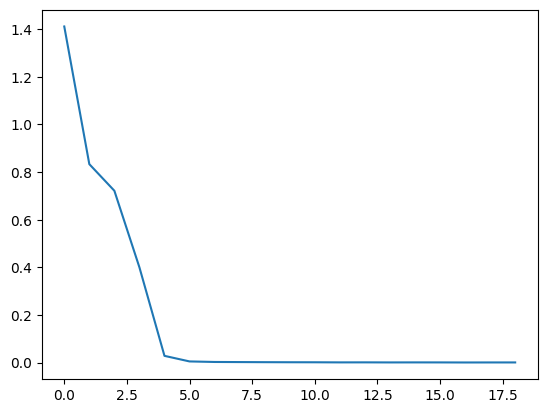

In [92]:
mlp_mat = MLP_matrix([2,2,1])

X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])


print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.reshape(-1, 1).T, False, 2000, 0.1)

plt.plot(error)
plt.show()

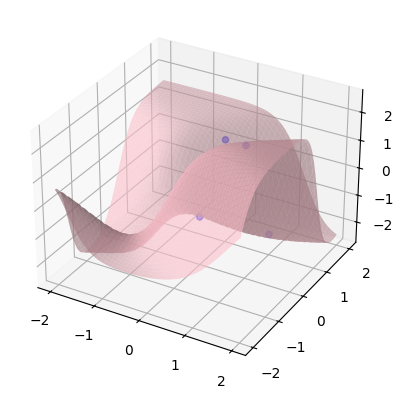

In [93]:
x1_values = np.linspace(-2, 2, 100)  # 10 points from 0 to 10
x2_values = np.linspace(-2, 2, 100)

# Create 2D grid from the two linspaces
x1_values, x2_values = np.meshgrid(x1_values, x2_values)

# flatten the grid to create input pairs
x1_values = x1_values.ravel()  # shape (100,)
x2_values = x2_values.ravel()

x_values = np.column_stack((x1_values, x2_values))

y_values = np.zeros((x_values.shape[0], 1))
# Get predictions for all points at once
for i in range(x_values.shape[0]):
    inp = x_values[i].reshape(-1, 1)
    y_values[i] = mlp_mat.predict(inp, False).reshape(-1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
# Reshape back to 2D grid (for surface plotting)
X1 = x_values[:, 0].reshape(100, 100)
X2 = x_values[:, 1].reshape(100, 100)
Y_pred = y_values.reshape(100, 100)

# Use plot_surface instead of scatter for smooth plane
ax.plot_surface(X1, X2, Y_pred, color='pink', alpha=0.6)
ax.scatter(X[:,0], X[:,1], Y, color='blue', label='Training data')
plt.show()

# TODO
- implem en C++